In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
!ls "/content/drive/MyDrive/resizes-images"

BrownSpot  Healthy  Hispa  LeafBlast


In [20]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
import os
from os import listdir
from PIL import Image

import tensorflow as tf
from tensorflow.keras.layers import Input
from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array , array_to_img
from keras.optimizers import Adam
from keras.utils import to_categorical


from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
def convert_image_to_array(image_dir):
  try:
      image = cv2.imread(image_dir)
      if image is not None :
         image = cv2.resize(image, (224, 224))
         return img_to_array(image)
      else :
        return np.array([])
  except Exception as e:
        print(f"Error : {e}")
        return None


In [13]:
import os

dir = "/content/drive/MyDrive/resizes-images"
image_list, label_list = [], []
all_labels = ['BrownSpot', 'Healthy', 'Hispa', 'LeafBlast']
binary_labels = [0, 1, 2, 3]
temp = -1

for directory in all_labels:
    plant_image_list = os.listdir(f"{dir}/{directory}")
    temp += 1
    for files in plant_image_list:
        image_path = f"{dir}/{directory}/{files}"
        image_list.append(convert_image_to_array(image_path))
        label_list.append(binary_labels[temp])


In [15]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.2, random_state = 10)


In [16]:
x_train = np.array(x_train, dtype=np.float16)/255.0
x_test = np.array(x_test, dtype=np.float16)/255.0
x_train = x_train.reshape(-1, 224, 224, 3)
x_test = x_test.reshape(-1, 224, 224, 3)



In [17]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [29]:
# Load MobileNetV2 base model (excluding top layers)
base_model = MobileNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)  # num_classes is the number of classes in your task

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=True)

In [27]:
# Train the model
history = model.fit(
    x_train, y_train,
    batch_size=16,
    epochs=10,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/10
77/77 [==============================] - 9s 95ms/step - loss: 0.9990 - accuracy: 0.5646 - val_loss: 3.5070 - val_accuracy: 0.4510
Epoch 2/10
77/77 [==============================] - 6s 76ms/step - loss: 0.8546 - accuracy: 0.6318 - val_loss: 10.6434 - val_accuracy: 0.4281
Epoch 3/10
77/77 [==============================] - 6s 78ms/step - loss: 0.7774 - accuracy: 0.6645 - val_loss: 10.1217 - val_accuracy: 0.4281
Epoch 4/10
77/77 [==============================] - 6s 75ms/step - loss: 0.7021 - accuracy: 0.7308 - val_loss: 10.2875 - val_accuracy: 0.4281


In [23]:
# Load the best weights
model.load_weights('best_model.h5')

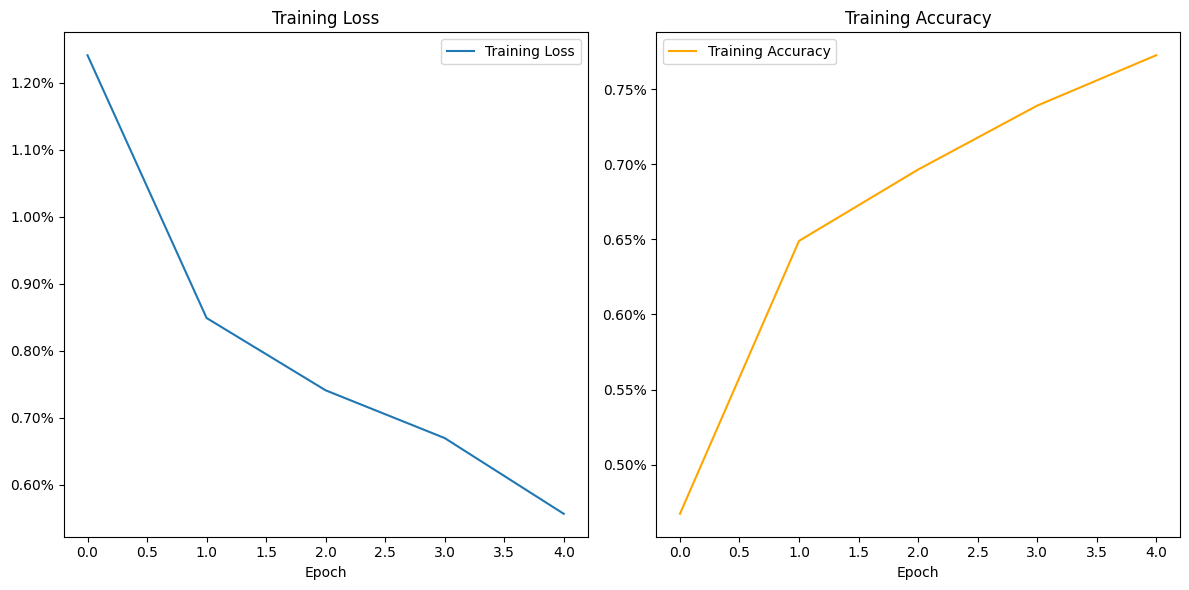

Overall Loss: 0.5564
Overall Accuracy: 0.7725


In [24]:
# Plot loss and accuracy graphs
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}%'))
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='orange')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}%'))
plt.legend()

plt.tight_layout()
plt.show()

# Print overall accuracy and loss
final_loss = history.history['loss'][-1]
final_accuracy = history.history['accuracy'][-1]

print(f"Overall Loss: {final_loss:.4f}")
print(f"Overall Accuracy: {final_accuracy:.4f}")



In [25]:
y_pred = model.predict(x_test)

10/10 [==============================] - 1s 43ms/step


In [26]:
correct_predictions = 0

for i in range(100):
    true_label = all_labels[np.argmax(y_test[i])]
    predicted_label = all_labels[np.argmax(y_pred[i])]

    print(true_label, "-", predicted_label)

    if true_label == predicted_label:
        correct_predictions += 1

print("Number of correct predictions:", correct_predictions)


LeafBlast - LeafBlast
LeafBlast - Hispa
Healthy - Hispa
LeafBlast - LeafBlast
BrownSpot - Hispa
Hispa - LeafBlast
LeafBlast - Hispa
LeafBlast - LeafBlast
LeafBlast - Hispa
Healthy - Hispa
LeafBlast - Hispa
Healthy - Hispa
LeafBlast - Hispa
LeafBlast - Hispa
LeafBlast - Hispa
LeafBlast - Hispa
LeafBlast - LeafBlast
Healthy - Hispa
LeafBlast - Hispa
Healthy - Hispa
LeafBlast - Hispa
Healthy - Hispa
LeafBlast - Hispa
Healthy - Hispa
LeafBlast - Hispa
LeafBlast - Hispa
LeafBlast - LeafBlast
Healthy - Hispa
Hispa - Hispa
Hispa - Hispa
Hispa - Hispa
LeafBlast - Hispa
LeafBlast - Hispa
Hispa - LeafBlast
Hispa - Hispa
Healthy - Hispa
Healthy - Hispa
LeafBlast - Hispa
Healthy - Hispa
LeafBlast - Hispa
Hispa - Hispa
LeafBlast - Hispa
BrownSpot - LeafBlast
BrownSpot - LeafBlast
LeafBlast - Hispa
LeafBlast - Hispa
Healthy - Hispa
Hispa - Hispa
Healthy - Hispa
Hispa - Hispa
Healthy - Hispa
LeafBlast - Hispa
Healthy - Hispa
Healthy - Hispa
LeafBlast - Hispa
LeafBlast - Hispa
Healthy - Hispa
Hispa - 